# A simple textual classifier for Dutch citizen reports
In many cities in the world local governments offer a service where citizens can make requests, for example to make a complaint about garbage on the street or to report nuisance. These reports are made by phone or trough a webform, by writing a text and selecting a category. The selection of a category can be done by using supervised machine learning on historical service requests. The city of Amsterdam uses this method to detect the class of an report and route it to the correct department. In this repository is the python code that can be used to create such a classifier.

The classification is done by using a TF-IDF (Term Freuqency - Inversed document frequency) as representation for the text and a logistic regression to classify the text. Optimal hyperparameters for the dataset are found using a gridsearch.

An example subset of data of dutch citizen reports is added for demonstration purposes. The original data used is not publicly available due to privacy concerns.

A live demo of a textual classification of Dutch service requets can be seen at http://ec2-54-171-141-211.eu-west-1.compute.amazonaws.com/
An example dataset of dutch citizen reports is added for demonstration purposes.

# Import data

#fields that are required
#Text, Main, Middle, Sub


# Develop algorithm

10172 rows loaded
7694 rows valid


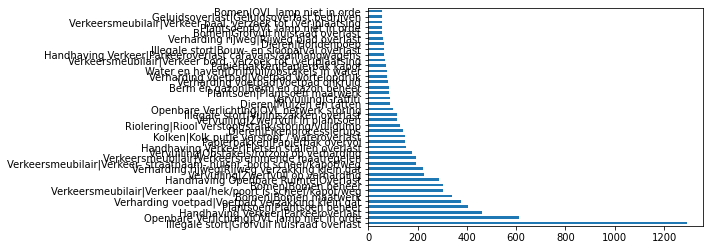

In [2]:
import pandas as pd

df = pd.read_csv('DB02062020.csv', engine='python')
#df = pd.read_excel('db.xls', sheet_name='bewerkt', index_col=0)
df = df.dropna(axis=0, how='any', thresh=None, subset=['Text', 'Main', 'Middle', 'Sub'], inplace=False)

# dump duplicates to csv file
#dupl = df[df.groupby(['Text'])['Main', 'Middle', 'Sub'].transform('nunique') > 1]
#dupl.sort_values(['Text', 'Main', 'Middle', 'Sub']).drop_duplicates(subset=['Text', 'Main', 'Middle', 'Sub'], keep=False).to_csv('duplicates2.csv', sep=',', encoding='utf-8', columns=['Text','Label'])

# cleanup dataset
df = df.drop_duplicates(subset=['Text'], keep='first')
# for dev use only a subset (for speed purpose)
df = df.sample(frac=.1).reset_index(drop=True)
# construct unique label
df['Label'] = df['Main'] + "|" + df['Middle'] + "|" + df['Sub']


print(len(df),'rows loaded') # The example dataset is not large enough to train a good classification model

number_of_examples = df['Label'].value_counts().to_frame()
df['is_bigger_than_50'] = df['Label'].isin(number_of_examples[number_of_examples['Label']>50].index)

df['is_bigger_than_50'].value_counts()

df = df[df['is_bigger_than_50'] == True]

print(len(df),'rows valid') # The example dataset is not large enough to train a good classification model

texts = df['Text']

# select the label. main, middle or sub.

#labels = df['sub']
#labels = df['middle']
#labels = df['main']

labels = df['Middle'] + '|' + df['Sub']
#labels = df['Label']

# Splitting data
split = 0.9
splitpoint = int(split*len(texts))

# train data
train_texts = texts[:splitpoint]
train_labels = labels[:splitpoint]

# test data
test_texts = texts[splitpoint:]
test_labels = labels[splitpoint:]

# visualize data distribution
labels.value_counts().plot(kind='barh').get_figure().savefig('dist.pdf')


In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

import warnings

from nltk.stem.snowball import DutchStemmer
import nltk
nltk.download('stopwords')
# init stemmer
stemmer=DutchStemmer(ignore_stopwords=True)

stop_words = set(nltk.corpus.stopwords.words('dutch'))
#print(stop_words)

import re
re_userid = re.compile("^([a-z]+\\:)")
def simple_preprocessor(text):
    text=text.lower()
    # text=re.sub(re_userid," ", text) # remove user name id
    text=re.sub("\\W"," ",text) # remove special chars
    
    # stem words
    words=re.split("\\s+",text)
    stemmed_words=[stemmer.stem(word=word) for word in words]
    return ' '.join(stemmed_words)

warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to /home/cuong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:

pipeline = Pipeline([
        #('vect', CountVectorizer(stop_words=stop_words)),
        ('vect', CountVectorizer(preprocessor=simple_preprocessor, stop_words=stop_words)),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression()),
])


# multiple hyperparameters, slow training, better optimization
parameters_slow = {
        'clf__class_weight': (None,'balanced'), #"balanced",
        'clf__max_iter': (300,500),  #500,1000
        'clf__penalty': ('l1',), #'l2',
        'clf__multi_class': ('auto',),
        'clf__solver': ('liblinear',), # lbfgs
        'tfidf__norm': ('l2',), # 'l1'
        'tfidf__use_idf': (False,),
        'vect__max_df': (1.0,),
        'vect__max_features': (None,),
        'vect__ngram_range': ((1, 1),(1,2)) # (1,2)
}
    # single hyperparameters, fast training, no optimization
parameters_fast = {
        'clf__class_weight': (None,), #"balanced",
        'clf__max_iter': (300,),  #500,1000
        'clf__penalty': ('l1',), #'l2',
        #'clf__multi_class': ('auto',),
        'clf__solver': ('liblinear',), # lbfgs
        'tfidf__norm': ('l2',), # 'l1'
        'tfidf__use_idf': (False,),
        'vect__max_df': (1.0,),
        'vect__max_features': (None,),
        'vect__ngram_range': ((1, 1),) # (1,2)
}

grid_search = GridSearchCV(pipeline, parameters_slow,verbose=True,n_jobs=15,cv=5)
grid_search.fit(train_texts, train_labels)


    # pipeline of classifier
#pipeline = Pipeline([
#        ('tfidf', TfidfVectorizer()),
#        ('clf', LogisticRegression()),
#])

# possible parameters to do gridsearch on
# More parameters can be found:
# TF-IDF vectorizer: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# Logistic regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
parameters_old = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__max_features': (None, 5000,),
    'tfidf__ngram_range': ((1, 1), (1, 2),), #(1, 3), (1, 4)), # using unigrams or bigrams or trigrams.
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__penalty': ('l2', 'l1'),
    'clf__max_iter': (10, 50, 80,100,150, 200),
}

#grid_search = GridSearchCV(pipeline, parameters)
#grid_search.fit(train_texts, train_labels)

print('Best parameters: ')
print(grid_search.best_params_)
print('')

print('Best score: ')
print(grid_search.best_score_)
print('')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  40 out of  40 | elapsed:   33.4s finished


Best parameters: 
{'clf__class_weight': None, 'clf__max_iter': 300, 'clf__multi_class': 'auto', 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__max_df': 1.0, 'vect__max_features': None, 'vect__ngram_range': (1, 1)}

Best score: 
0.5745212954654535



# Model persistence
http://scikit-learn.org/stable/modules/model_persistence.html

Saving the model to be able to use it for making predictions later.

In [5]:
# from sklearn.externals import joblib
import joblib
joblib.dump(grid_search, 'model-db.pkl') 

model = joblib.load('model-db.pkl') 

# Evaluation

Evaluation using precision, recall and accuracy

In [6]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

test_predict = model.predict(test_texts)

precision = str(round(precision_score(test_labels, test_predict, average='macro', zero_division=0),2))
recall = str(round(recall_score(test_labels, test_predict, average='macro'),2))
accuracy = str(round(accuracy_score(test_labels, test_predict),2))

print('Precision', precision)
print('Recall', recall)
print('Accuracy', accuracy)
#test_labels.value_counts().plot(kind='barh')

Precision 0.49
Recall 0.42
Accuracy 0.59


# Re use






In [7]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, test_predict, labels=test_labels, zero_division=0))

                                                                      precision    recall  f1-score   support

                                                 Vervuiling|Graffiti       0.86      1.00      0.92         6
                       Verharding rijweg|Rijweg verzakking klein gat       0.47      0.43      0.45        21
                      Verkeersmeubilair|Verkeersremmende maatregelen       0.38      0.16      0.22        19
                         Handhaving Verkeer|Fietsen stallen overlast       0.58      0.92      0.71        12
                                          Plantsoen|Plantsoen beheer       0.79      0.79      0.79        53
                                 Handhaving Openbare Ruimte|Overlast       0.50      0.30      0.38        33
Verkeersmeubilair|Verkeer- straatnaam-,huisnr.-bord scheef/kapot/weg       0.62      0.54      0.58        24
          Verkeersmeubilair|Verkeer bord, verzoek tot (ver)plaatsing       0.00      0.00      0.00         6
         

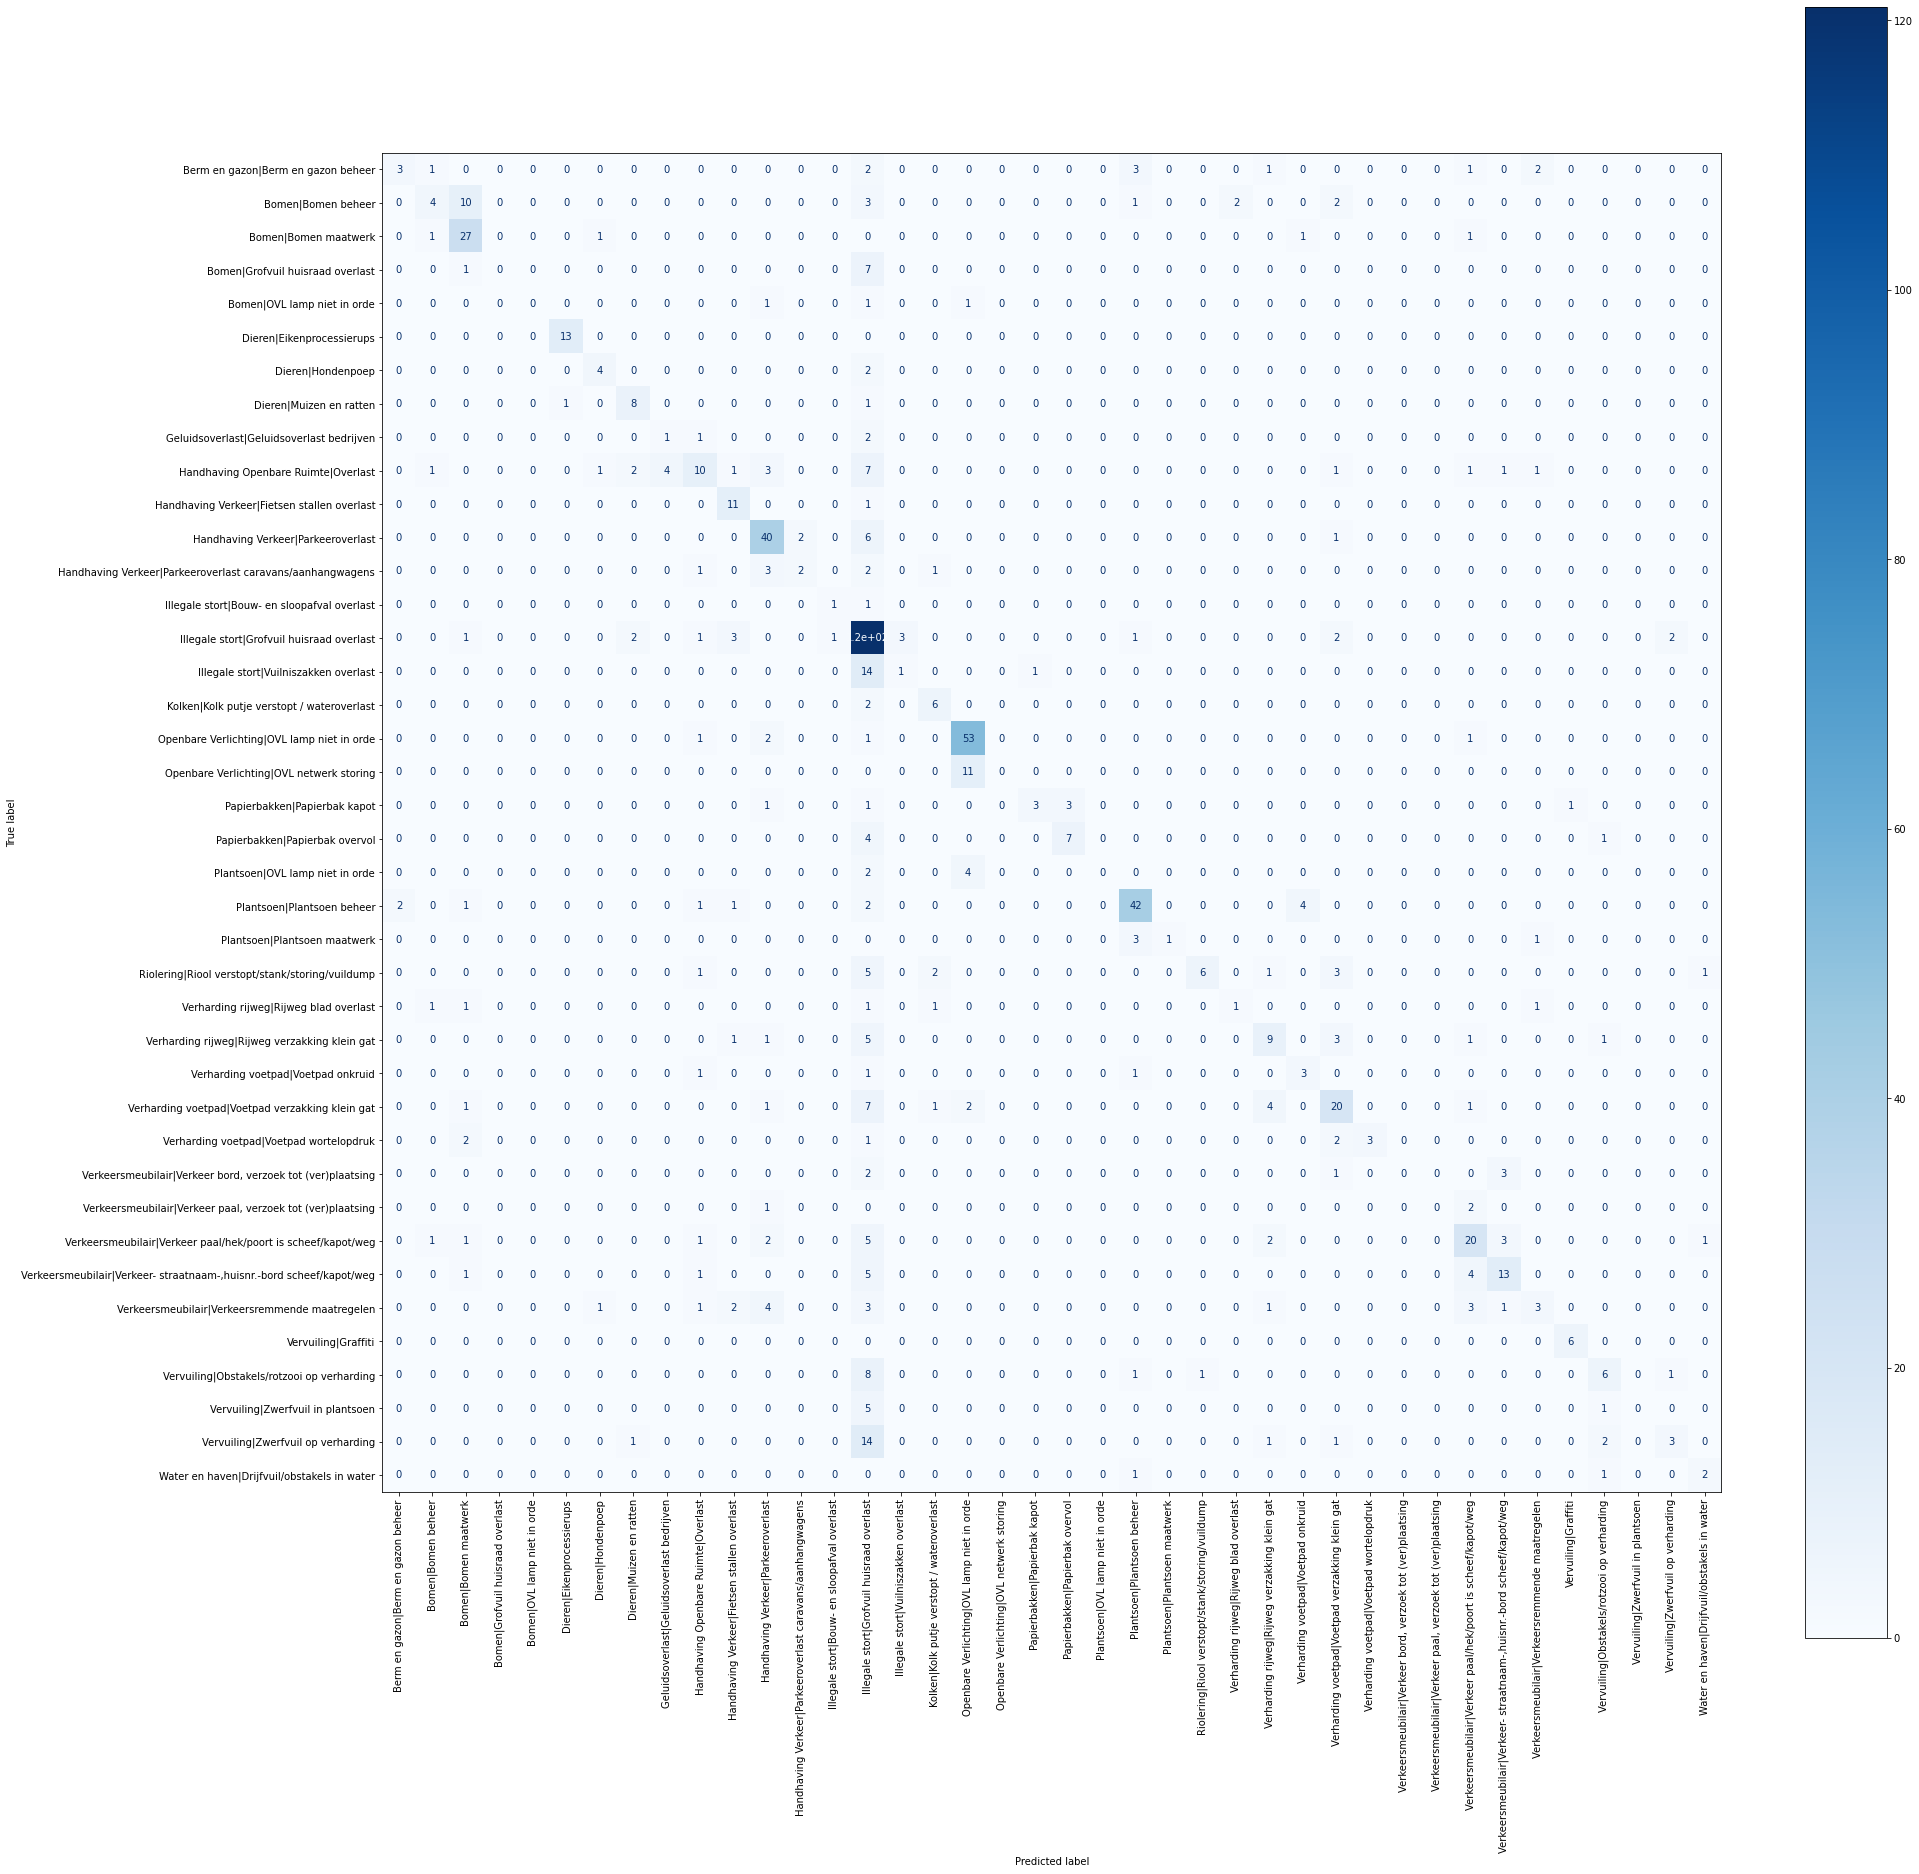

In [8]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,30)

#display_labels = [x.split('|')[-1] for x in test_labels]
#print(set(display_labels))

disp = plot_confusion_matrix(model, test_texts, test_labels,
                                 #display_labels=display_labels,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                 xticks_rotation='vertical')
plt.savefig("mat.pdf")
plt.show()


In [9]:
# dump matrix to csv
from pprint import pprint
#pprint(vars(disp))
#values = [[i._text for i in line] for line in disp.text_]

df2 = pd.DataFrame(disp.confusion_matrix, columns=disp.display_labels)
df2.to_csv('matrix.csv')

In [10]:
# show mispredicted items
for input, prediction, label in zip(test_texts, test_predict, test_labels):
  if prediction != label:
    print(input, ' \npredicted: ', prediction, ' actual: ', label, '\n') 

Verzaking van op rit tussen de weg en de fietspad en er zijn ook een paar pionnen tussen de weg en de fietspad vanaf gereden  
predicted:  Vervuiling|Obstakels/rotzooi op verharding  actual:  Verharding rijweg|Rijweg verzakking klein gat 

suzm: afgebroken verkeersbord in de bosjes gedumpt bij Karperborch, ter hoogte van het basketveldje in Rosmalen.  
predicted:  Illegale stort|Grofvuil huisraad overlast  actual:  Verkeersmeubilair|Verkeer- straatnaam-,huisnr.-bord scheef/kapot/weg 

lava: Borden in West - sector 322 voor vergunninghouders nog niet verwijders. Sinds 01-01-2020 geen vergunninghoudersgebied meer. Graag borden verwijderen om verwarring te voorkomen.  
predicted:  Verkeersmeubilair|Verkeer- straatnaam-,huisnr.-bord scheef/kapot/weg  actual:  Verkeersmeubilair|Verkeer bord, verzoek tot (ver)plaatsing 

susw: mevrouw wil de stavaza omtrent melding 260163 weten, er wordt nog steeds veel brood gestrooid in de gemeentetuinen
door meneer hoek, Jan Heinsstraat 49. Er komt hier v

In [13]:
model.predict_proba(['afval naast container gedumpt'])

array([[0.00429954, 0.00835433, 0.00620341, 0.00277766, 0.00350489,
        0.0021594 , 0.00178777, 0.00162652, 0.00365624, 0.01740615,
        0.002778  , 0.00431846, 0.00192708, 0.01460406, 0.74267587,
        0.03876744, 0.00465394, 0.00775901, 0.00270886, 0.00303586,
        0.00513096, 0.00337911, 0.007462  , 0.00562812, 0.00877425,
        0.00264095, 0.00727688, 0.00193309, 0.00617088, 0.00200925,
        0.00450334, 0.00442579, 0.01737371, 0.00893866, 0.01026425,
        0.002458  , 0.0116467 , 0.00102227, 0.00529953, 0.00865778]])

In [14]:
model.predict(['afval naast container gedumpt'])

array(['Illegale stort|Grofvuil huisraad overlast'], dtype=object)